In [487]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [488]:
from pylamp.neural.layers import Linear
from pylamp.neural.activations import Sigmoid, TanH, ReLU
from pylamp.optim.optimizer import SGD
from pylamp.loss.losses import BCELoss, MSELoss
from pylamp.utils.data import DataGenerator as dg 

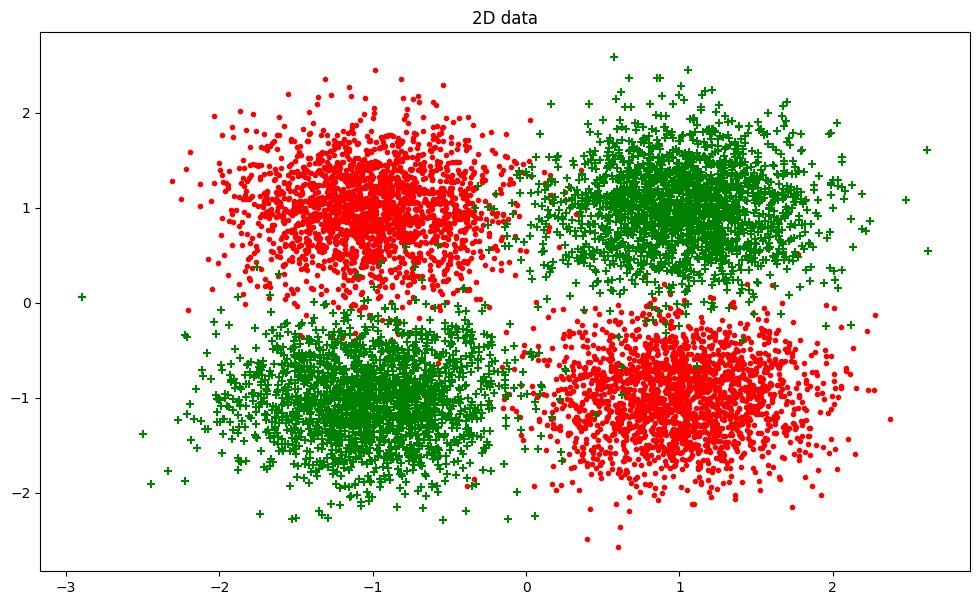

In [489]:
X_train, X_test, y_train, y_test  = dg.generate_2D_data(data_type=1, epsilon=0.3, train_size=0.8, nbex=10000)
dg.plot_2D_data(X_train, y_train)

In [490]:
class ModelTest():
    def __init__(self, models) -> None:
        self.models = models
    
    def forward(self,X):
        output = X 
        for model in self.models:
            output = model.forward(output)
        return output

In [491]:
input_size = X_train.shape[1]
hidden_size = 8
output_size = y_train.shape[1]

print(f'input_size: {input_size}, output_size: {output_size}')

fc1 = Linear(input_size, hidden_size, use_bias=True)
fc2 = Linear(hidden_size, output_size, use_bias=True)
tanh = TanH()
sigmoid = Sigmoid()
model_to_plot = ModelTest([fc1,tanh,fc2,sigmoid])
loss = BCELoss()
train_loss = SGD.step_multiple(
    fc1,fc2,tanh,sigmoid, loss, X_train=X_train, y_train=y_train, 
    epochs=300, lr=1e-3, batch_size=256, verbose=True,
    plot_boundary = True, model_to_plot=model_to_plot
)

Epoch 270 : Train loss : 0.04145852980106441
Model updated 9300 times.


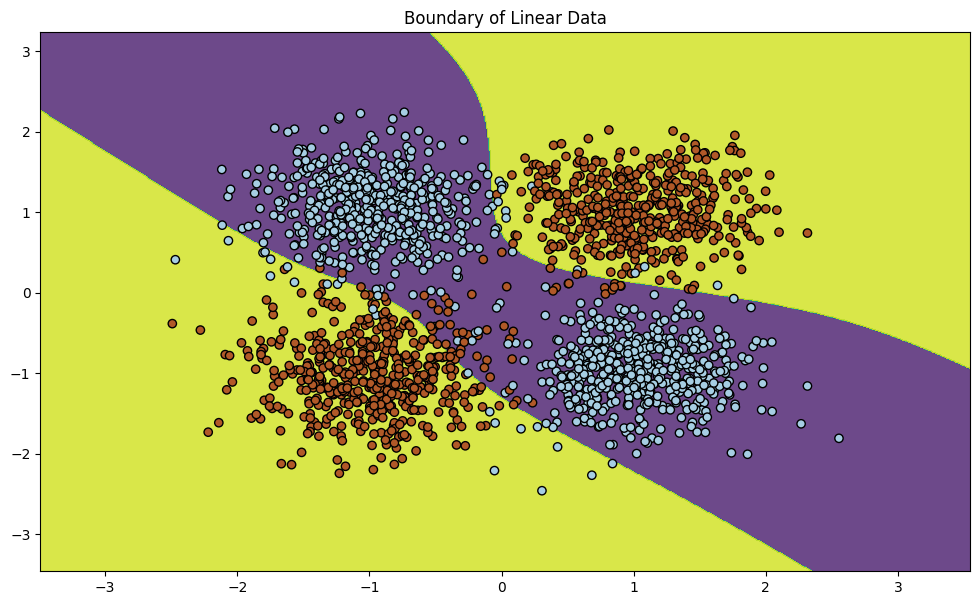

In [492]:
dg.plot_decision_boundary(X_test, y_test, model_to_plot, "Boundary of Linear Data")